<a href="https://colab.research.google.com/github/rishuatgithub/MLPy/blob/master/Topic_Modelling_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modelling using Latent-Dirichlet Allocation

- Blog URL : [Topic Modelling : Latent Dirichlet Allocation, an introduction](https://anotherreeshu.wordpress.com)
- Author   : Rishu Shrivastava

In [0]:
## required installation for LDA visualization
!pip install pyLDAvis

## imports

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyLDAvis
from pyLDAvis import sklearn
pyLDAvis.enable_notebook()

### Step 1: Loading and Understanding Data

<div class="active active-primary">
As part of this step we will load an existing dataset and load it into a pandas dataframe. We will also try to on a brief understand the data.

- Source of the dataset is from Kaggle [News category classifer](https://www.kaggle.com/hengzheng/news-category-classifier-val-acc-0-65).</div>

In [0]:
### Reading the dataset from path

filename = 'News_Category_Dataset_v2.json'
data = pd.read_json(filename, lines=True)
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [0]:
### data dimensions (rows, columns) of the dataset we are dealing with

data.shape

(200853, 6)

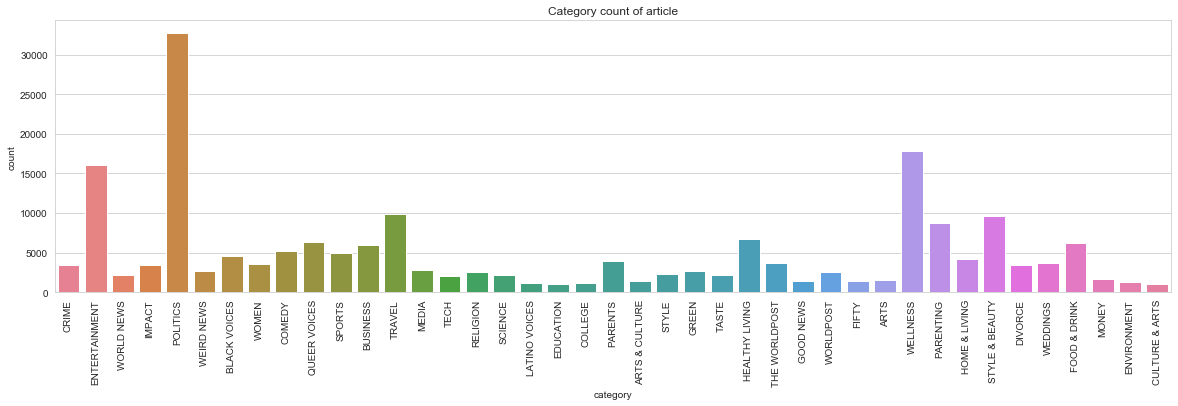

In [0]:
### Total articles by category spread - viz

plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
sns.countplot(x='category',data=data, orient='h', palette='husl')
plt.xticks(rotation=90)
plt.title("Category count of article")
plt.show()

<div class ="alert alert-success">As we can see in the above diagram, a lot of new relates to Politics and its related items. Also we can understand a total of 20 new categories are defined in this dataset. So as part of Topic modelling exercise we can try to categories the dataset into 20 topics.
</div>

### Step 2: Transforming the dataset

<div class="alert alert-warning">For the purpose of this demo and blog, we will do the following:

  1.   **Combine** both the **Headline and Short Description** into one single column to bring more context to the news and corpus. Calling it as: ```Combined_Description```
  2.  **Drop** rest of the attributes from the dataframe other than Combined_Description and Categories.
    
</div>

In [0]:
### tranform the dataset to fit the original requirement

data['Combined_Description'] = data['headline'] + data['short_description']

filtered_data = data[['category','Combined_Description']]

filtered_data.head()

,category,Combined_Description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


In [0]:
## checking the dimensions of filtered data
filtered_data.shape

(200853, 2)

<div class="alert alert-warning">
    <b>Applying TFIDFVectorizer to pre-process the data into vectors.</b>

- max_df : Ignore the words that occurs more than 95% of the corpus. 
- min_df : Accept the words in preparation of vocab that occurs in atleast 2 of the documents in the corpus.
- stop_words : Remove the stop words. We can do this in separate steps or in a single step.
</div>

In [0]:
df_tfidf = TfidfVectorizer(max_df=0.5, min_df=10, stop_words='english', lowercase=True)

In [0]:
df_tfidf_transformed = df_tfidf.fit_transform(filtered_data['Combined_Description'])

In [0]:
df_tfidf_transformed

<200853x21893 sparse matrix of type '<class 'numpy.float64'>'
	with 2740307 stored elements in Compressed Sparse Row format>

<div class="alert alert-success"> 
Here you can notice that the transformed dataset holds a sparse matrix with a dimension of 200853x21893; where 200853 is the total number of rows and 21893 is the total word corpus.
</div>

### Step 3: Building Latent-Dirichlet Algorithm using scikit-learn

In [0]:
### Define the LDA model and set the topic size to 20.

topic_clusters = 20

lda_model = LatentDirichletAllocation(n_components=topic_clusters, batch_size=128, random_state=42)

In [0]:
### Fit the filtered data to the model

lda_model.fit(df_tfidf_transformed)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

<div class="alert alert-danger">
Note: Fitting the model to the dataset take a long time. You will see the output as model summary, if success.
</div>

### Step 4: LDA Topic Cluster

In [0]:
topic_word_dict = {}

top_n_words_num = 10

for index, topic in enumerate(lda_model.components_):
  topic_id = index
  topic_words_max = [df_tfidf.get_feature_names()[i] for i in topic.argsort()[-top_n_words_num:]]
  topic_word_dict[topic_id] = topic_words_max

  print(f"Topic ID : {topic_id}; Top 10 Most Words : {topic_words_max}")

Topic ID : 0; Top 10 Most Words : ['gun', 'police', 'violence', 'health', 'people', 'school', 'new', 'study', 'sexual', 'women']
Topic ID : 1; Top 10 Most Words : ['stewart', 'flint', 'rico', 'storm', 'climate', 'new', 'jon', 'puerto', 'hurricane', 'water']
Topic ID : 2; Top 10 Most Words : ['crash', 'police', 'airlines', 'cup', 'driver', 'coffee', 'colbert', 'man', 'stephen', 'car']
Topic ID : 3; Top 10 Most Words : ['new', 'photo', 'hair', 'week', 'look', 'dress', 'style', 'wedding', 'fashion', 'photos']
Topic ID : 4; Top 10 Most Words : ['years', 'players', 'saudi', 'nfl', 'old', 'man', 'football', 'year', 'francis', 'pope']
Topic ID : 5; Top 10 Most Words : ['day', 'love', 'make', 'don', 'need', 'things', 'know', 'people', 'time', 'life']
Topic ID : 6; Top 10 Most Words : ['dead', 'olympic', 'killed', 'drag', 'israel', 'year', 'festival', 'new', 'police', 'film']
Topic ID : 7; Top 10 Most Words : ['movie', 'year', 'williams', 'trailer', 'isis', 'jennifer', 'netflix', 'new', 'wars',

<div class="alert alert-warning">
Transforming the existing dataframe and adding the content with a topic id and LDA generated topics
<div>

In [0]:
topic_output = lda_model.transform(df_tfidf_transformed)

In [0]:
filtered_data = filtered_data.copy()

filtered_data['LDA_Topic_ID'] = topic_output.argmax(axis=1)

filtered_data['Topic_word_categories'] = filtered_data['LDA_Topic_ID'].apply(lambda id: topic_word_dict[id])

In [0]:
filtered_data[['category','Combined_Description','LDA_Topic_ID','Topic_word_categories']].head()

,category,Combined_Description,LDA_Topic_ID,Topic_word_categories
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,0,"[gun, police, violence, health, people, school..."
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,2,"[crash, police, airlines, cup, driver, coffee,..."
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...,7,"[movie, year, williams, trailer, isis, jennife..."
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,13,"[ban, judge, white, news, hill, president, don..."
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,13,"[ban, judge, white, news, hill, president, don..."


### Step 6: Visualizing

In [0]:
viz = sklearn.prepare(lda_model=lda_model, dtm=df_tfidf_transformed, vectorizer=df_tfidf)

In [0]:
pyLDAvis.display(viz)

<div class="alert alert-warning">
    The above chart visualizes the distribution of LDA topic and prints out a list of most used topics
    </div>